# 5.3. Experiments and Evaluation

### Utility Code

In [ ]:
# Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import numpy as np
from typing import List
import warnings

warnings.filterwarnings(
    "ignore"
)  # Disable long warnings when NaN values are encountered

In [ ]:
# Constants
# color palette source: https://www.practicalpythonfordatascience.com/ap_seaborn_palette

geographical_palette = sns.color_palette("terrain", 8)
orbital_palette = sns.color_palette("Dark2", 8)
latitudinal_palette = sns.color_palette("tab10", 8)

qualitative_case_palettes = {
    "Landlocked": geographical_palette,
    "Coastal": geographical_palette,
    "IntraOrbital": orbital_palette,
    "TransOrbital": orbital_palette,
    "Polar": latitudinal_palette,
    "Equatorial": latitudinal_palette,
}

directions = ["East", "West"]  # , "North", "South"]

imax_list = ["OFF", "3", "3", "9"]

log_directory = "../../simulator/Logs/"

In [ ]:
# Utility functions
from abc import ABC


def load_csv_data(relative_path: str):
    # TODO: should be named load_csv_data
    """Load CSV data."""
    path = os.path.join(log_directory, relative_path)
    assert os.path.isfile(path)
    return pd.read_csv(path)


def load_json_data(relative_path: str):
    """Load JSON data."""
    path = os.path.join(log_directory, relative_path)
    assert os.path.isfile(path)
    with open(path) as file:
        data = json.load(file)
    return pd.DataFrame(data["latencies"])


class Plot(ABC):
    def __init__(self):
        pass

    def plot(self):
        """Draw a single plot."""
        raise NotImplementedError

    def multi_plot(self):
        """Draw multiple plots."""
        raise NotImplementedError

## 1. Probability of Congestion relative to $i_\text{max}$
Plot the probability of congestion relative to $i_\text{max}$ using spare capacity data retrieved from the simulator for $i_\text{max} \in \{3, 6, 9\}$..

## 1. Network Performance relative to $i_\text{max}$
Plots the network performance relative to $i_\text{max}$ for $i_\text{max} \in \{3, 6, 9\}$.

In [ ]:
valid_types = {"cdf", "time-series"}

# I think the stuff below is mostly utility functions. Some of this needs to be cleaned up by the way.


class MedianLatency(Plot):
    def __init__(self):
        self.data_df = pd.DataFrame()
        pass

    def get_data(self, scenario: str, direction: str, imax: int, reps: int):
        # Concatenate data from different iterations into a single DataFrame.
        aggregate_data = []
        for i in range(0, reps):
            filename = f"{scenario}_{direction}_{imax}_{i:03d}/rtt.json"
            data = load_json_data(filename).explode("rtt", ignore_index=True)
            data["direction"] = direction
            aggregate_data.append(data)
        return pd.concat(aggregate_data, axis=0, ignore_index=True)

    def _cdf_plot(self, scenario, direction, data_df):
        sns.ecdfplot(
            data=data_df,
            x="rtt",
            # y="rtt",
            label=(
                f"{scenario} {direction}"
                if data_df["rtt"].notna().any()
                else "__nolegend__"
            ),
            legend=True,
        )

    def _timeseries_plot(self, scenario, direction, data_df):
        # Plot the data
        sns.lineplot(
            data=data_df,
            x="frame",
            y="rtt",
            label=(
                f"{scenario} {direction}"
                if data_df["rtt"].notna().any()
                else "__nolegend__"
            ),
            legend=True,
        )

        pass

    def _plot(self, scenario: str, direction: str, imax: int, reps: int, **kwargs):
        """
        NOTE: plot_type defaults to line
        """
        assert reps >= 0

        data_df = self.get_data(scenario, direction, imax, reps)

        if "plot_type" in kwargs and kwargs["plot_type"] == "cdf":
            self._cdf_plot(scenario, direction, data_df)
        else:
            self._timeseries_plot(scenario, direction, data_df)

    def single_plot(
        self, scenario: str, direction: str, imax: int, reps: int, **kwargs
    ):
        self._plot(scenario, direction, imax, reps, **kwargs)
        plt.tight_layout()
        plt.legend()
        plt.show()

    def multi_plot(
        self,
        scenario: str,
        directions: List[str],
        imax_list: List[str],
        reps: int,
        **kwargs,
    ):
        """Plot the results for all combinations of qualitative cases and a given imax value.

        Args:
            plot_fn (Callable): _description_
            qualitative_case (str): _description_
            imax_list (List[int]): _description_
            reps (int): _description_
        """
        for imax in imax_list:
            for direction in directions:
                self._plot(scenario, direction, imax, reps, **kwargs)
        plt.tight_layout()
        plt.legend()
        plt.show()


sns.set_palette(latitudinal_palette)
MedianLatency().multi_plot(
    "Landlocked", ["East", "West"], ["3", "6"], 5, plot_type="cdf"
)
MedianLatency().multi_plot(
    "Landlocked", ["East", "West"], ["3", "6"], 5, plot_type="lineplot"
)

In [ ]:
############################################
# Currently contains eastwards, westwards, #
# northwards, and southwards directions.   #
# Directions, i_maxes, and cases are all   #
# in the same graph (for now)              #
# i_max \in {1, 3, 6, 9}                   #
############################################

sns.set_palette(geographical_palette)

geographical_cases = list(qualitative_case_palettes.keys())


# Cumulative Distribution Function (of RTT)
# TODO: WRITE THIS CORRECTLY.
# for geographical_case in geographical_cases:
#     MedianLatency(plot_median_latency, geographical_case, imax_list=imax_list, reps=100, plot_type="cdf")

# # # Time-series Line Plot
# for geographical_case in geographical_cases:
#     plot_results(plot_median_latency, geographical_case, imax_list=imax_list, reps=100, plot_type="line-plot")

## 2. Simulated Probability of Congestion relative to $i_\text{max}$
Plot the probability of congestion relative to $i_\text{max}$ using spare capacity data retrieved from the simulator for $i_\text{max} \in \{3, 6, 9\}$..

In [ ]:
%%script false --no-raise-error

# TODO: I THINK THIS HASNT PROGRESSED MUCH.

class CongestionProbability(Plot):
    def __init__(self):
        pass

    def get_data(self):
        pass

    def plot(self, scenario: str, direction: str, imax: str):
        total_successes = 0
        total_attempts = 0
        for i in range(0, reps):
            filename = f"{scenario}_{direction}_{imax}_{i:03d}/attack.csv"
            data = load_csv_data(filename)
            if 0.0 in data["FINAL CAPACITY"].value_counts():
                total_successes += data["FINAL CAPACITY"].value_counts()[0.0]
            total_attempts += len(data)
        probability = total_successes/total_attempts
        return probability
        sns.barplot(
            x=f"{qualitative_case}", # {direction}",
            y=probability,
            # color=palette[idx],
            # ax=ax,
            
            label=f"{qualitative_case} {direction}",
            legend=True
        )
        # return True
        # pass

    def single_plot(self):

        pass

    def multi_plot(self):
        pass

def plot_probability_congestion(qualitative_case, direction, imax, reps, **kwargs) -> float:
    total_successes = 0
    total_attempts = 0
    for i in range(0, reps):
        filename = f"{qualitative_case}_{direction}_{imax}_{i:03d}/attack.csv"
        data = load_csv_data(filename)
        if 0.0 in data["FINAL CAPACITY"].value_counts():
            total_successes += data["FINAL CAPACITY"].value_counts()[0.0]
        total_attempts += len(data)
    probability = total_successes/total_attempts
    return probability
    sns.barplot(
        x=f"{qualitative_case}", # {direction}",
        y=probability,
        # color=palette[idx],
        # ax=ax,
        
        label=f"{qualitative_case} {direction}",
        legend=True
    )
    return True


fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for ax in axs:
    # ax.set_xlabel("Snapshot")
    ax.set_ylabel("Probability of Congestion")
    # ax.set_ylim(-.5, 20.5)  # TODO: CHANGE THIS.
    # ax.tick_params(axis="y", labelcolor="black")
    ax.grid(True)

    # Remove the subplot if there is no data.
    if len(ax.get_lines()) == 0:
        fig.delaxes(ax)

plt.tight_layout()
plt.legend()
plt.show()

## 3. Simulated Expected Malicious Traffic relative to $i_\text{max}$

#### Utility Code

In [39]:
class ExpectedMaliciousTraffic(Plot):

    def _get_data(
        self, scenario: str, direction: str, imax_list: List[int], reps: int
    ) -> pd.DataFrame:
        aggregate_data = []
        # print(reps)
        for (
            direction
        ) in directions:  # TODO: DIRECTIONS IS IMPORTANT TOO> NEED TO USE THIS.
            for imax in [3, 6, 9]:  # kwargs["imaxes"]:
                # print(imax)
                imax = f"{imax}" if imax != 1 else "OFF"
                agg_data = []
                # Concatenate data from different iterations into a single DataFrame.
                for i in range(0, reps):  # ran 100 instances.
                    filename = f"{scenario}_{direction}_{imax}_{i:03d}/attack.csv"
                    # assert(os.path.isfile(filename))
                    i_data = load_csv_data(filename).explode(
                        "FINAL CAPACITY", ignore_index=True
                    )
                    # i_data['FINAL CAPACITY'] = i_data['FINAL CAPACITY'].apply(lambda x: abs(x - 20000)) # TODO: AND MAKE SURE ITS NOT IN MBITS BUT IN GBITS PER SEC
                    i_data["direction"] = f"{scenario} {direction}"
                    i_data["imax"] = imax
                    agg_data.append(i_data)
                new = pd.concat(agg_data, axis=0, ignore_index=True)
                aggregate_data.append(new)

        return pd.concat(aggregate_data, axis=0, ignore_index=True)

    def _barplot(self, data_df: pd.DataFrame):
        sns.displot(
            data=data_df,
            x="imax",
            y="FINAL CAPACITY",
            legend=True,
            # palette=palette,
            hue="direction",
            ci="sd",
            capsize=0.2,
            estimator=np.mean,
        )

    def _plot(
        self, scenario: str, direction: str, imax_list: List[str], reps: int, **kwargs
    ):
        assert reps >= 0
        data_df = self._get_data(scenario, direction, imax_list, reps)
        self._barplot(data_df)

    def single_plot(
        self, scenario: str, direction: str, imax_list: int, reps: int, **kwargs
    ):
        self._plot(scenario, direction, imax_list, reps, **kwargs)
        plt.tight_layout()
        plt.legend()
        plt.show()

    def multi_plot(self):
        raise NotImplementedError

#### Results

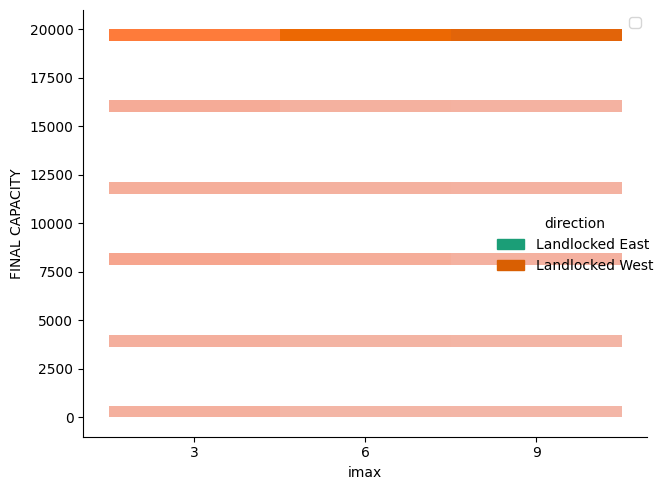

In [40]:
sns.set_palette(orbital_palette)
# Cumulative Distribution Function (of RTT)
for geographical_case in {"Landlocked"}:
    ExpectedMaliciousTraffic().single_plot(
        geographical_case,
        "East",
        imax_list={3, 6, 9},
        reps=100,
        plot_type="line",
        imaxes=[3, 6, 9],
    )